In [1]:
import os
import glob

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV

import seaborn as sns

In [2]:
path = 'data/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_from_file = (pd.read_csv(f, sep=',') for f in csv_files)
df_football = pd.concat(df_from_file, ignore_index = True)

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,SBH,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH
0,9.0,9.0,0.0,16.0,6.0,0.0,Malaga,3.2,3.25,2.25,...,NaN,3.00,3.25,2.40,3.40,3.3,2.30,3.2,3.30,2.25
1,4.0,14.0,0.0,13.0,5.0,2.0,Espanol,3.8,3.30,2.00,...,NaN,3.75,3.25,2.10,4.10,3.5,2.00,3.8,3.25,2.05
2,8.0,17.0,0.0,10.0,3.0,4.0,Getafe,5.5,3.75,1.62,...,NaN,5.50,3.60,1.67,6.00,3.8,1.67,4.8,3.75,1.70
3,4.0,17.0,0.0,13.0,9.0,2.0,Betis,4.2,3.50,1.83,...,NaN,4.50,3.50,1.83,4.33,3.7,1.87,4.0,3.50,1.91
4,1.0,12.0,0.0,5.0,2.0,3.0,Sociedad,26.0,9.00,1.10,...,NaN,29.00,9.00,1.10,31.00,12.0,1.10,29.0,11.00,1.07


# Conociendo y preparando los datos

In [3]:
df_football.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BSA', 'BSD', 'BSH', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
       'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD',
       'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD',
       'BbMxH', 'BbOU', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'GBA', 'GBD',
       'GBH', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY',
       'HomeTeam', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSA', 'PSCA',
       'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'SBA', 'SBD', 'SBH', 'SJA',
       'SJD', 'SJH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH'],
      dtype='object')

Text(0.5,0,'percentage')

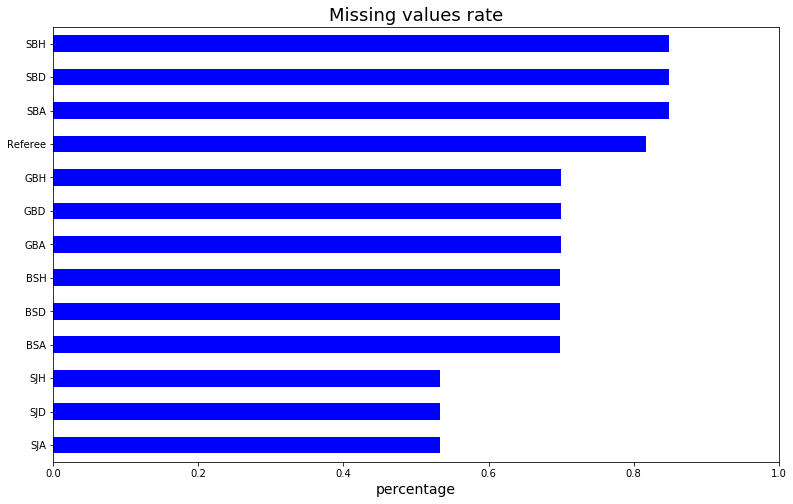

In [4]:
null_data = df_football.isnull().mean()

plt.figure(figsize = (13, 8))
null_data[null_data >= 0.3].sort_values().plot.barh(color = 'blue')
plt.xlim(xmax = 1)
plt.title("Missing values rate", fontsize = 18)
plt.xlabel("percentage", fontsize = 14)

In [5]:
features_no_null = null_data[null_data < 0.3].index
    
df = df_football[features_no_null]
df = df.fillna(round(df.mean(), 2))

df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
0,9.0,9.0,0.0,16.0,6.0,0.0,Malaga,3.2,3.25,2.25,...,3.45,2.35,3.38,2.31,3.40,3.3,2.30,3.2,3.30,2.25
1,4.0,14.0,0.0,13.0,5.0,2.0,Espanol,3.8,3.30,2.00,...,3.33,2.25,3.56,2.00,4.10,3.5,2.00,3.8,3.25,2.05
2,8.0,17.0,0.0,10.0,3.0,4.0,Getafe,5.5,3.75,1.62,...,3.96,1.68,3.94,1.65,6.00,3.8,1.67,4.8,3.75,1.70
3,4.0,17.0,0.0,13.0,9.0,2.0,Betis,4.2,3.50,1.83,...,3.49,2.17,3.77,1.89,4.33,3.7,1.87,4.0,3.50,1.91
4,1.0,12.0,0.0,5.0,2.0,3.0,Sociedad,26.0,9.00,1.10,...,13.96,1.09,12.00,1.10,31.00,12.0,1.10,29.0,11.00,1.07


In [6]:
ftr_dummies = pd.get_dummies(df.FTR, prefix='FTR')
df = pd.concat([df, ftr_dummies], axis = 1)

htr_dummies = pd.get_dummies(df.HTR, prefix='HTR')
df = pd.concat([df, htr_dummies], axis = 1)

df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,VCH,WHA,WHD,WHH,FTR_A,FTR_D,FTR_H,HTR_A,HTR_D,HTR_H
0,9.0,9.0,0.0,16.0,6.0,0.0,Malaga,3.2,3.25,2.25,...,2.30,3.2,3.30,2.25,1,0,0,0,1,0
1,4.0,14.0,0.0,13.0,5.0,2.0,Espanol,3.8,3.30,2.00,...,2.00,3.8,3.25,2.05,0,0,1,0,1,0
2,8.0,17.0,0.0,10.0,3.0,4.0,Getafe,5.5,3.75,1.62,...,1.67,4.8,3.75,1.70,0,0,1,0,0,1
3,4.0,17.0,0.0,13.0,9.0,2.0,Betis,4.2,3.50,1.83,...,1.87,4.0,3.50,1.91,1,0,0,1,0,0
4,1.0,12.0,0.0,5.0,2.0,3.0,Sociedad,26.0,9.00,1.10,...,1.10,29.0,11.00,1.07,0,0,1,0,0,1


In [7]:
variables_to_remove = ["Date", "FTR", "HTR"]

df = df.drop(variables_to_remove, axis=1)
df.shape

(13698, 67)

In [8]:
df.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5',
       'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5',
       'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU',
       'Div', 'FTAG', 'FTHG', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG',
       'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSA',
       'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD',
       'WHH', 'FTR_A', 'FTR_D', 'FTR_H', 'HTR_A', 'HTR_D', 'HTR_H'],
      dtype='object')

# Prediciendo la variable FTHG

```python
features_to_predict = ['FTHG', 'FTAG', 'FTR_A', 'FTR_D', 'FTR_H', 
                       'HTHG', 'HTAG', 'HTR_A', 'HTR_D', 'HTR_H', 
                       'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 
                       'AF', 'HY', 'AY', 'HR', 'AR']

features = ['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
            'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD',
            'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD',
            'BbMxH', 'BbOU', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSA', 'PSCA', 
            'PSCD', 'PSCH', 'PSD', 'PSH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']
```

In [37]:
features = ['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
            'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD',
            'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD',
            'BbMxH', 'BbOU', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSA', 'PSCA', 
            'PSCD', 'PSCH', 'PSD', 'PSH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']

df_y = df['FTHG']
df = pd.concat([df[features], df_y], axis=1)

df.head()

,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,...,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH,FTHG
0,3.2,3.25,2.25,3.25,3.40,2.25,38.0,21.0,-0.25,1.78,...,2.35,3.38,2.31,3.40,3.3,2.30,3.2,3.30,2.25,0.0
1,3.8,3.30,2.00,4.10,3.30,2.00,38.0,20.0,-0.50,1.68,...,2.25,3.56,2.00,4.10,3.5,2.00,3.8,3.25,2.05,2.0
2,5.5,3.75,1.62,5.50,3.75,1.60,38.0,23.0,-0.75,1.84,...,1.68,3.94,1.65,6.00,3.8,1.67,4.8,3.75,1.70,2.0
3,4.2,3.50,1.83,4.10,3.50,1.85,38.0,18.0,-0.75,1.92,...,2.17,3.77,1.89,4.33,3.7,1.87,4.0,3.50,1.91,3.0
4,26.0,9.00,1.10,23.00,10.00,1.08,35.0,23.0,-2.75,3.36,...,1.09,12.00,1.10,31.00,12.0,1.10,29.0,11.00,1.07,5.0


In [ ]:
sns.pairplot(df)

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_ex

# Separación de datos de entrenamiento y test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_y = df['FTHG']
df_X = df[features]
def df_X['FTHG']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.25, random_state = 42)

In [11]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (10273, 42)
X_test:  (3425, 42)
y_train: (10273,)
y_test:  (3425,)


# Regresión lineal básica

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
reg_LR = LinearRegression()
reg_LR_fit = reg_LR.fit(X_train, y_train)
y_pred_LR = reg_LR.predict(X_test)

In [14]:
print('Intercept: ', reg_LR.intercept_)
print('Coefficients:')
list(zip(df_X.columns, reg_LR.coef_))

Intercept:  3.11112311728
Coefficients:


[('B365A', 0.031670738323746436),
 ('B365D', -0.049784078437583978),
 ('B365H', 0.073971994087412923),
 ('BWA', 0.011224730455574965),
 ('BWD', -0.085137348631821042),
 ('BWH', -0.011695122772014089),
 ('Bb1X2', 0.0055069646601889214),
 ('BbAH', -0.0040961418619074206),
 ('BbAHh', -0.4607236135165011),
 ('BbAv<2.5', 0.039697211002356569),
 ('BbAv>2.5', -0.24877511138041303),
 ('BbAvA', 0.038632898375090166),
 ('BbAvAHA', -0.05392665151873282),
 ('BbAvAHH', -0.63253087862258373),
 ('BbAvD', 0.24489446377255952),
 ('BbAvH', -0.13948520959354277),
 ('BbMx<2.5', 0.095837628073203979),
 ('BbMx>2.5', -0.21131030975744602),
 ('BbMxA', -0.042884980539330299),
 ('BbMxAHA', -0.060852197330125479),
 ('BbMxAHH', 0.24479947499839649),
 ('BbMxD', 0.0082798790811371512),
 ('BbMxH', 0.023746124900323781),
 ('BbOU', -0.0056890791845826977),
 ('IWA', -0.052082209452988082),
 ('IWD', 0.033652836559028676),
 ('IWH', -0.020653586775938714),
 ('LBA', 0.01085084404532162),
 ('LBD', 0.012438078227988078),
 ('

In [15]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))

Mean squared error: 1.41
Variance score: 0.18


# Lasso

In [25]:
from sklearn.linear_model import Lasso, LassoCV

### Lasso CV para conocer alpha

In [17]:
alphas = np.logspace(-4, -0.5, 30)
alphas

array([  1.00000000e-04,   1.32035178e-04,   1.74332882e-04,
         2.30180731e-04,   3.03919538e-04,   4.01280703e-04,
         5.29831691e-04,   6.99564216e-04,   9.23670857e-04,
         1.21957046e-03,   1.61026203e-03,   2.12611233e-03,
         2.80721620e-03,   3.70651291e-03,   4.89390092e-03,
         6.46167079e-03,   8.53167852e-03,   1.12648169e-02,
         1.48735211e-02,   1.96382800e-02,   2.59294380e-02,
         3.42359796e-02,   4.52035366e-02,   5.96845700e-02,
         7.88046282e-02,   1.04049831e-01,   1.37382380e-01,
         1.81393069e-01,   2.39502662e-01,   3.16227766e-01])

In [18]:
lasso_CV = LassoCV(cv=10, n_jobs=-1, normalize=True, alphas=alphas)
lasso_CV.fit(df_X, df_y)

best_alpha_lasso_CV = lasso_CV.alpha_

print('Score: \n', lasso_CV.score(df_X, df_y))
print('Alpha: \n', lasso_CV.alpha_)
print('CV: \n', lasso_CV.coef_)

Score: 
 0.180921763229
Alpha: 
 0.0001
CV: 
 [  0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00  -5.16012422e-03   0.00000000e+00  -0.00000000e+00
  -4.48695354e-01   1.25251212e-01  -3.41215978e-01   0.00000000e+00
   2.14981911e-01  -2.66238277e-02   0.00000000e+00  -1.06165833e-02
   4.19967282e-02  -4.22869927e-02   0.00000000e+00   0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -3.71829155e-03   0.00000000e+00
   0.00000000e+00  -2.66108516e-04   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
   1.15484143e-02   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00]


In [19]:
lasso = Lasso(normalize=True, alpha=best_alpha_lasso_CV)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Mean squared error: 1.41
Variance score: 0.18


### Lasso con cross_val_predict

In [27]:
cv_outer = KFold(n_splits = 10)

lasso = LassoCV(cv = 10, n_jobs = -1, normalize=True, alphas=alphas)
# lasso = Lasso(normalize=True)

# scores = cross_val_score(lasso, df_X, df_y, cv=cv_outer)

predicted = cross_val_predict(lasso, df_X, df_y, cv=cv_outer)

print("Mean squared error: %.2f" % mean_squared_error(df_y, predicted))
print('Variance score: %.2f' % r2_score(df_y, predicted))

Mean squared error: 1.40
Variance score: 0.18


### Lasso con GridSearchCV

In [24]:
lasso = Lasso(normalize=True)

tuned_parameters = [{'alpha': alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds)
clf.fit(df_X, df_y)

best_alpha_lasso_GS = clf.best_params_['alpha']
print('Best Alpha: \n', best_alpha_lasso_GS)

Best Alpha: 
 0.0001


In [22]:
lasso = Lasso(normalize=True, alpha=best_alpha_lasso_GS)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Mean squared error: 1.41
Variance score: 0.18


In [23]:
list(zip(df_X.columns, lasso.coef_))

[('B365A', 0.0069996830875549611),
 ('B365D', 0.0),
 ('B365H', -0.0),
 ('BWA', 0.0),
 ('BWD', 0.0),
 ('BWH', -0.0059103757251269713),
 ('Bb1X2', 0.0),
 ('BbAH', -0.0),
 ('BbAHh', -0.47454099318586351),
 ('BbAv<2.5', 0.0),
 ('BbAv>2.5', -0.25905224282717404),
 ('BbAvA', 0.0),
 ('BbAvAHA', 0.0),
 ('BbAvAHH', -0.2020614984191933),
 ('BbAvD', 0.0),
 ('BbAvH', -0.0),
 ('BbMx<2.5', 0.10996842721557629),
 ('BbMx>2.5', -0.15278848505694911),
 ('BbMxA', 0.0),
 ('BbMxAHA', 0.0),
 ('BbMxAHH', -0.0),
 ('BbMxD', 0.0),
 ('BbMxH', -0.0),
 ('BbOU', -6.5611939629557815e-05),
 ('IWA', 0.0),
 ('IWD', 0.0),
 ('IWH', -0.0),
 ('LBA', 0.0),
 ('LBD', 0.0),
 ('LBH', -0.0),
 ('PSA', 0.0),
 ('PSCA', 0.0),
 ('PSCD', 0.0),
 ('PSCH', -0.007358822088053666),
 ('PSD', 0.0),
 ('PSH', -0.0),
 ('VCA', 0.0044646494970505208),
 ('VCD', 0.0),
 ('VCH', -0.0),
 ('WHA', 0.0),
 ('WHD', -0.0),
 ('WHH', -0.0)]

# Árbol de decisión

In [28]:
from sklearn.tree import DecisionTreeRegressor

### Árbol de decisión básico

In [30]:
reg_DT = DecisionTreeRegressor()
reg_DT.fit(X_train, y_train)
y_pred_reg_DT = reg_DT.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Mean squared error: 2.89
Variance score: -0.68


### Árbol de decisión con kfold

In [32]:
kfold = KFold(n_splits=10)

reg_DT_kfold = DecisionTreeRegressor()
y_pred_reg_DT_kfold = cross_val_predict(reg_DT_kfold, X_train, y_train, cv=kfold)

print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred_reg_DT_kfold))
print('Variance score: %.2f' % r2_score(y_train, y_pred_reg_DT_kfold))

Mean squared error: 2.90
Variance score: -0.70


### Árbol de decisión con GridSearch

In [33]:
params = {'max_depth': range(1, 30),
          'min_samples_split': range(2, 30, 5),
          'min_samples_leaf': range(5, 40, 5)}

reg_DT_gscv = DecisionTreeRegressor()
gscv_reg_DT = GridSearchCV(estimator=reg_DT_gscv, param_grid=params, cv=5, n_jobs=-1)

gscv_reg_DT.fit(df_X, df_y)
print(gscv_reg_DT.best_params_)

{'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 20}


In [36]:
reg_DT_tunned = DecisionTreeRegressor(min_samples_split=12, min_samples_leaf=20, max_depth=4)
reg_DT_tunned.fit(X_train, y_train)
y_pred_reg_DT_tunned = reg_DT_tunned.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT_tunned))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT_tunned))

Mean squared error: 1.43
Variance score: 0.17
